In [2]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import cm

In [3]:
nx = 41
ny = 41
l = 1.
h = 1.
dx = l/(nx-1)
dy = h/(ny-1)
l1_target = 1e-6
x = numpy.linspace(0,l,nx)
y = numpy.linspace(0,h,ny)
psi0 = numpy.zeros((ny,nx))
w0 = numpy.zeros((ny,nx))
utop = 1
uleft = 0
uright = 0
ubottom = 0
d = dx

In [4]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [5]:
def mylaplacepoisson_nest(psi, w, l1_target):
    
    iterations = 0
    normw = l1_target+1 #init normw to be larger than l1_target
    normpsi = l1_target+1 #init normpsi to be larger than l1_target
   
    while (normw > l1_target or normpsi > l1_target): #à priori qd w converge, psi cvg
        
        w_n = w.copy()
        psi_n = psi.copy()
        
        
        w[1:-1,1:-1] = .25 * (w_n[1:-1,:-2] + w_n[1:-1,2:] + w_n[:-2,1:-1] + w_n[2:,1:-1])
        
        
        #Neumann 2nd-order BC
       
        
        #psi[:,0] = 0
        #psi[:,-1] = 0
        
       
        #psi[0,:] = 0
        #psi[-1,:] = 0
        w[0,:] = ((-1/(2*d**2)) * (8*psi[1,:] - psi[2,:] )) + 3*ubottom/d
        w[-1,:] = ((-1/(2*d**2)) * (8*psi[-2,:] - psi[-3,:] )) - 3*utop/d #7*psi pas dans l'énoncé?????
        w[:,0] = ((-1/(2*d**2)) * (8*psi[:,1] - psi[:,2] )) + 3*uleft/d
        w[:,-1] = ((-1/(2*d**2)) * (8*psi[:,-2] - psi[:,-3] )) - 3*uright/d
        psi[1:-1,1:-1] = .25 * ((psi_n[1:-1,2:] + psi_n[1:-1,:-2] +\
                        psi_n[2:,1:-1] + psi_n[:-2,1:-1]) + w[1:-1,1:-1]*d**2)
       
        normw =  L1norm(w_n, w)
    
        normpsi = L1norm(psi_n, psi)
        
    
        iterations += 1
        
    return psi, w, iterations, normw, normpsi, psi_n, w_n

In [6]:
psi, w, iterations, normw, normpsi, psi_n, w_n = mylaplacepoisson_nest(psi0, w0, l1_target)

In [7]:
print (psi[:])

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.41429633e-06   2.17360371e-06 ...,   2.17360371e-06
    1.41429633e-06   0.00000000e+00]
 [  0.00000000e+00   2.20482439e-06   1.45898816e-07 ...,   1.45898816e-07
    2.20482439e-06   0.00000000e+00]
 ..., 
 [  0.00000000e+00  -6.35061518e-03  -1.52288240e-02 ...,  -1.52288240e-02
   -6.35061518e-03   0.00000000e+00]
 [  0.00000000e+00  -7.32622358e-03  -1.33638594e-02 ...,  -1.33638594e-02
   -7.32622358e-03   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


In [8]:
print(iterations, normw, normpsi)

4060 9.99748579551e-07 2.22733131185e-08


In [9]:
#%%timeit
#mylaplacepoisson_nest(psi0, w0, l1_target)

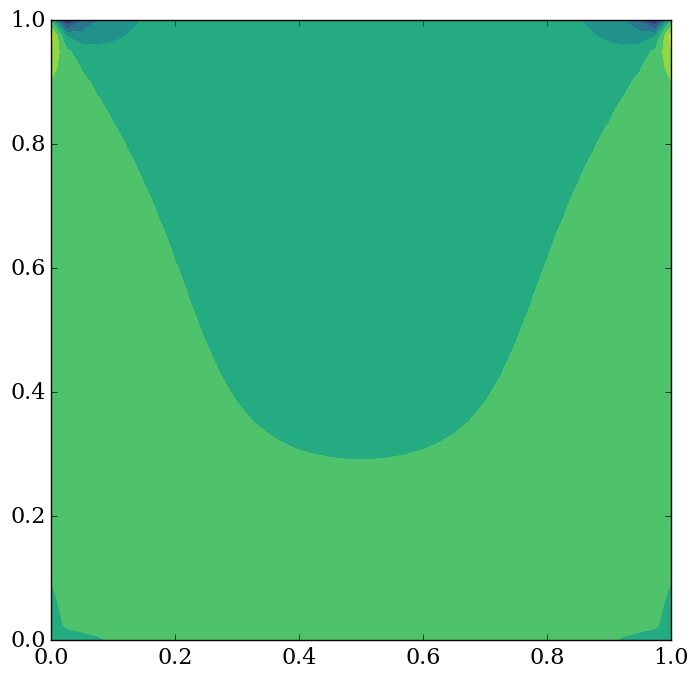

In [10]:
pyplot.figure(figsize=(8,8))
pyplot.contourf(x,y,w,10,cmap=cm.viridis)

In [11]:
print ((numpy.max(numpy.abs(psi[1:-1,1:-1]))),numpy.max(numpy.abs(psi[:])))

0.0998451724383 0.0998451724383


In [12]:
print ((numpy.max(numpy.abs(w[1:-1,1:-1]))),numpy.max(numpy.abs(w[:])))

22.5607771651 78.1926612286


In [ ]:
numpy.round(psi[32,::8], 4)

In [ ]:
maxpsi=0
for i in range (nx):
    for j in range (ny):
        if numpy.abs(psi[i,j])>= maxpsi:
            maxpsi=numpy.abs(psi[i,j])
print (maxpsi)


In [ ]:
maxw=0
for i in range (nx):
    for j in range (ny):
        if numpy.abs(w[i,j])>= maxw:
            maxw=numpy.abs(w[i,j])
print (maxw)


In [ ]:
numpy.round(w[40,::8], 4)

In [ ]:
#byebye
def mylaplacepoisson(psi, w, l1_target):
    
    iterations = 0
    normw = l1_target+1 #init normw to be larger than l1_target
    normpsi = l1_target+1 #init normpsi to be larger than l1_target
   
    while (normw > l1_target): #à priori qd w converge, psi cvg
        
        w_n = w.copy()
        psi_n = psi.copy()
        
        
        for j in range (1,ny-1):
            for i in range (1,nx-1):
                w[j,i] = .25 * (w_n[j,i-1] + w_n[j,i+1] + w_n[j-1,i] + w_n[j+1,i])
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psi_n[j,i+1] + psi_n[j,i-1])*dy**2 +\
                        (psi_n[j+1,i] + psi_n[j-1,i])*dx**2 +\
                         w[j,i]*dx**2*dy**2)
        #Neumann 2nd-order BC
       
        for j in range (ny):
            psi[j,0] = 0
            psi[j,-1] = 0
            w[j,0] = ((-1/(2*dx**2)) * (8*psi_n[j,1] - psi_n[j,2] )) + 3*uleft/dx
            w[j,-1] = ((-1/(2*dx**2)) * (8*psi_n[j,-2] - psi_n[j,-3] )) - 3*uright/dx
        for i in range(nx):
            psi[0,i] = 0
            psi[-1,i] = 0
            w[0,i] = ((-1/(2*dy**2)) * (8*psi_n[1,i] - psi_n[2,i] )) + 3*ubottom/dx
            w[-1,i] = ((-1/(2*dy**2)) * (8*psi_n[-2,i] - psi_n[-3,i] )) - 3*utop/dy #7*psi pas dans l'énoncé?????
            
        normw =  L1norm(w_n, w)
    
        normpsi = L1norm(psi_n, psi)
        
    
        iterations += 1
       
        
    return psi, w, iterations, normw, normpsi